
# Deep Docstring Generation
---

This notebook describes, step by step, how we built our Deep Docstring Generator. The notebook is organized in different sections:


>1. **Creation of the Dataset instance**, in order to properly manage the data. 
>2. **Creation and training** of the **Neural Machine Translation Model** with that training data.
>3. Applying the trained model on **new (unseen) data**.

In [ ]:
# Get the Greatest Common Divisor of a and b
def get_GCD(a, b):    
    while (b != 0):
        if (a > b):
            a -= b
        else:
            b -= a
    return a

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
!cat /proc/cpuinfo

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 60
model name	: Intel(R) Core(TM) i7-4790 CPU @ 3.60GHz
stepping	: 3
microcode	: 0xffffffff
cpu MHz		: 3591.689
cache size	: 8192 KB
physical id	: 0
siblings	: 8
core id		: 0
cpu cores	: 4
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology cpuid pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm invpcid_single pti ssbd ibrs ibpb stibp fsgsbase bmi1 avx2 smep bmi2 erms invpcid xsaveopt flush_l1d arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs itlb_multihit srbds
bogomips	: 7183.37
clflush size	: 64
cache_alignment	: 64
address sizes	: 39 bits physical, 48 bits virtual
power management:

processor	: 1
vendor_

In [5]:
%matplotlib inline

In [6]:
# %tensorflow_version 1.x

UsageError: Line magic function `%tensorflow_version` not found.


In [8]:
!pip3 install git+https://github.com/MarcBS/keras.git

  Cloning https://github.com/MarcBS/keras.git to /tmp/pip-req-build-umv18u3k
  Running command git clone -q https://github.com/MarcBS/keras.git /tmp/pip-req-build-umv18u3k


In [9]:
import os
os.chdir("./")
!git clone https://github.com/lvapeab/nmt-keras
!pip3 uninstall -y keras
os.chdir('nmt-keras')
!pip3 install -e .

fatal: destination path 'nmt-keras' already exists and is not an empty directory.
Found existing installation: Keras 2.3.1.1
Uninstalling Keras-2.3.1.1:
  Successfully uninstalled Keras-2.3.1.1
Obtaining file:///mnt/c/Users/sagun/Downloads/ComGen/nmt-keras
  Using cached https://github.com/MarcBS/keras/archive/master.zip
  Created wheel for keras: filename=Keras-2.3.1.1-py3-none-any.whl size=487500 sha256=8aa0b895eacdf012df3bc9d8bc4a458003e516868d12b2562315d441dfe8cafd
  Stored in directory: /tmp/pip-ephem-wheel-cache-6z0d1nx7/wheels/68/86/9b/290dd8e0919a4070424e29c34886fbcf85d437c53506723c08
Successfully built keras
  Attempting uninstall: nmt-keras
    Found existing installation: nmt-keras 0.6
    Uninstalling nmt-keras-0.6:
      Successfully uninstalled nmt-keras-0.6
  Running setup.py develop for nmt-keras


In [10]:
from sklearn.model_selection import train_test_split
import sys
import pandas as pd
import numpy as np
import os
import tensorflow as tf
import csv

In [11]:
import keras

Using TensorFlow backend.


In [12]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.ERROR)

In [13]:
!python3 -c "import keras; print(keras.__version__)"
!python3 -c "import tensorflow; print(tensorflow.__version__)"

Using TensorFlow backend.
2.3.1
1.15.0


In [14]:
import tensorflow as tf
tf.test.is_gpu_available()

False

In [15]:
!pip3 install more-itertools

## 1. Building a Dataset model
First, we are creating a [Dataset](https://github.com/MarcBS/multimodal_keras_wrapper/keras_wrapper/dataset.py) object (from the [Multimodal Keras Wrapper](https://github.com/MarcBS/multimodal_keras_wrapper) library). This object will be the interface between our data (text files) and the model:

In [16]:
from keras_wrapper.dataset import Dataset, saveDataset
from data_engine.prepare_data import keep_n_captions
dataset = Dataset('tutorial_dataset', 'tutorial', silence=False)

Now that we have the empty dataset, we must indicate its inputs and outputs. In our case, we'll have two different inputs and one single output:

1. Outputs:
**target_text**: Sentences in our target language.

2. Inputs:
**source_text**: Sentences in the source language.

**state_below**: Sentences in the target language, but shifted one position to the right (for teacher-forcing training of the model).

For setting up the outputs, we use the setOutputs function, with the appropriate parameters. Note that, when we are building the dataset for the training split, we build the vocabulary (up to 30000 words).

In [17]:
working_dir = "./"
os.chdir(working_dir)
file_path = working_dir + "alldata-allfields-withtypes-parens-uniques.csv"
docstring_header = "docstring"
ast_header = "ast"
start_word = "<start>"  # start token
end_word = "<end>"  # end token

In [18]:
n_parallel_loaders = 3
beam_size = 6 if tf.test.is_gpu_available() else 1
# beam_size = 3 if tf.test.is_gpu_available() else 1
# tokenize_y = "tokenize_montreal"
# tokenize_x = "tokenize_soft"
batch_size = 72 #200 #230 #72 #280 #140 #230
tokenize_y = "tokenize_none"
tokenize_x = "tokenize_none"
# tokenize_y = "tokenize_soft"
# tokenize_x = "tokenize_soft"

In [19]:
# The dataset is already cleaned, so need to run this cell

# # from more_itertools import unique_everseen

# open(file_path, 'w').close()
# # with open(file_path_raw,'r') as in_file, open(file_path,'a+') as out_file:
# #     out_file.writelines(unique_everseen(in_file))
# with open(file_path_raw,'r') as in_file, open(file_path,'a+') as out_file:    
#   seen = set() # set for fast O(1) amortized lookup
#   for line in in_file:
#       if line in seen: continue # skip duplicate
#       seen.add(line)
#       out_file.write(line)

In [20]:
import string
import re
import random

def create_dataset(path_to_file, num_examples=None):

    iterations = 0
    docstring_data, ast_data = [], []
    d_lens, a_lens = [], []
    d_lens_filtered, a_lens_filtered = [], []
    print(path_to_file,num_examples)

    def preprocesser_d(x):
      x = x.replace('\n', ' ').strip().lower()
      x = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', x) #remove various punctuations
      x = re.sub(r'^https?:\/\/.*[\r\n]*', ' ', x) #remove url
      return x

    preprocesser_a = lambda x: x.replace(' \n', ' ').strip().lower()

    try:
        with open(path_to_file,"r") as dataset:
            reader = csv.DictReader((line.replace('\0','') for line in dataset))
            for row in reader:

                if num_examples and iterations == num_examples:
                  break

                rdh = row[docstring_header]
                rah = row[ast_header]
                if rdh and rah:
                  d_words = preprocesser_d(rdh)
                  d_words_split = [word for word in d_words.split() if word]
                  d_words = ' '.join(d_words_split)
                  d_words_len = len(d_words_split)

                  a_words = preprocesser_a(rah)
                  a_words_split = [a for a in a_words.split() if a and a not in ('(',')')]
                  a_words = ' '.join(a_words_split)
                  a_words_len = len(a_words_split)

                  d_lens.append(d_words_len)
                  a_lens.append(a_words_len)

                  # if 20 <= a_words_len <= 100 and d_words_len >= 2:
                  if 25 <= a_words_len and d_words_len >= 2:
                    # docstring_data.append(f"{start_word} {d_words} {end_word}\n")
                    docstring_data.append(f"{d_words}\n")
                    ast_data.append(f"{a_words}\n")
                    d_lens_filtered.append(d_words_len)
                    a_lens_filtered.append(a_words_len)
                    iterations += 1
        
        indices = set()
        # if num_examples:
        #   indices = set(random.sample(range(iterations), num_examples))
        #   ast_data = [ast_data[i] for i in range(len(ast_data)) if i in indices]
        #   a_lens_filtered = [len(s) for s in ast_data]
        #   docstring_data = [docstring_data[i] for i in range(len(docstring_data)) if i in indices]
        #   d_lens_filtered = [len(s) for s in docstring_data]

        print("Finished reading dataset")
        print("d_lens max & avg",max(d_lens),sum(d_lens)/len(d_lens))
        print("d_lens_f max & avg",max(d_lens_filtered),sum(d_lens_filtered)/len(d_lens_filtered))
        print("a_lens max & avg",max(a_lens),sum(a_lens)/len(a_lens))
        print("a_lens_f max & avg",max(a_lens_filtered),sum(a_lens_filtered)/len(a_lens_filtered))

        return ast_data, docstring_data, a_lens, d_lens, a_lens_filtered, d_lens_filtered, indices if len(indices) else set()
    except Exception as e:
        print('Error loading dataset', e)

In [21]:
os.chdir('..')

In [22]:
num_examples = 25000 #10000 #None #5000
x, y, x_lens, y_lens, x_lens_f, y_lens_f, indices = create_dataset(file_path, num_examples)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1)
len(x_train),len(x_val),len(x_test),len(y_train),len(y_val),len(y_test)

./alldata-allfields-withtypes-parens-uniques.csv 25000
Finished reading dataset
d_lens max & avg 1508 24.50902450159793
d_lens_f max & avg 1508 27.9506
a_lens max & avg 8176 113.89706285192513
a_lens_f max & avg 8176 143.62556


(20250, 2250, 2500, 20250, 2250, 2500)

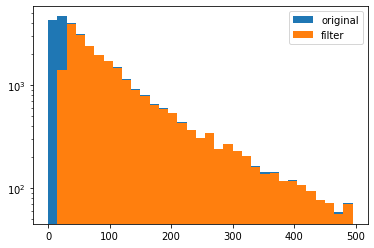

In [23]:
import numpy as np    
import matplotlib.pyplot as plt
plt.hist(x_lens, bins=np.arange(0,500,15),log=True,label="original")
plt.hist(x_lens_f, bins=np.arange(0,500,15),log=True,label="filter")
plt.legend();

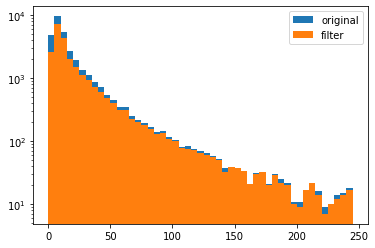

In [24]:
import numpy as np    
import matplotlib.pyplot as plt
plt.hist(y_lens, bins=np.arange(0,250,5),log=True,label="original")
plt.hist(y_lens_f, bins=np.arange(0,250,5),log=True,label="filter")
plt.legend();

In [25]:
x_train[0:25]

['functiondef args3 arguments arg arg arg constant str assign name store args1 name load int assign name store args3 name load name load name load args0 attribute name load load assign name store list load assign name store args1 attribute name load load int for name store args1 name load args0 attribute name load load assign name store args1 attribute name load load name load assign name store args2 name load subscript name load index int load subscript name load index int load call args1 attribute name load load name load assign name store args1 attribute name load load list name load load call args1 attribute name load load name load return name load\n',
 'functiondef args2 arguments arg arg constant str if compare name load is nonetype return bool assign name store args1 attribute name load load name load if args1 attribute name load load name load assign subscript name load index name load store name load return bool return bool name load\n',
 'functiondef args1 arguments arg cons

In [26]:
y_train[0:25]

['reprojects the bounding box crssrc source crs ogrpoly ogr polygon\n',
 'fallback imputation for shapes use the default symbol usually the last symbol in the list bool true if there was any missing data\n',
 'before template render hook\n',
 'get a task state as a string\n',
 'verify that the upf raises no exceptions for several reasonable choices of rbins\n',
 'compose a name and write output file\n',
 'returns the number of cpus in the system borrowed from the python processing package\n',
 'activityrate a model defined in swagger\n',
 'validate a meta argument\n',
 'send a message to the control and wait for it to return or to timeout if no timeout is given then a default timeout of 01 of a second will be used\n',
 'secret share an abstracttensor secret abstracttensor the tensor to share a pair of abstracttensor the shares\n',
 'type driver class mesoshttp client mesosclient schedulerdriver\n',
 'creates player s based on the selected items and adds to the queue if the active menu 

In [27]:
x_max_text_len = 300 #300 #140 #142 #142
y_max_text_len = 10 #50 #30
x_max_words = 200 #30000 #100 #15000 #31000 
y_max_words = 30000 #20000 #14500 #20000 #26000 #35000 #33000
y_min_occ = 0 #2

In [28]:
import time

open('x_train.txt', 'w').close()
with open(os.path.join(working_dir, 'x_train.txt'), 'a+') as datafile:
  datafile.writelines(x_train)
  print(len(x_train))

open('y_train.txt', 'w').close()
with open(os.path.join(working_dir, 'y_train.txt'), 'a+') as datafile:
  datafile.writelines(y_train)
  print(len(y_train))

open('x_val.txt', 'w').close()
with open(os.path.join(working_dir, 'x_val.txt'), 'a+') as datafile:
  datafile.writelines(x_val)
  print(len(x_val))

open('y_val.txt', 'w').close()
with open(os.path.join(working_dir, 'y_val.txt'), 'a+') as datafile:
  datafile.writelines(y_val)
  print(len(y_val))

open('x_test.txt', 'w').close()
with open(os.path.join(working_dir, 'x_test.txt'), 'a+') as datafile:
  datafile.writelines(x_test)
  print(len(x_test))

open('y_test.txt', 'w').close()
with open(os.path.join(working_dir, 'y_test.txt'), 'a+') as datafile:
  datafile.writelines(y_test)
  print(len(y_test))

20250
20250
2250
2250
2500
2500


In [29]:
dataset.setOutput('y_train.txt',
             'train',
             type='text',
             id='target_text',
             tokenization=tokenize_y,
             build_vocabulary=True,
             pad_on_batch=True,
             sample_weights=True,
             max_text_len=y_max_text_len,
             max_words=y_max_words,
             min_occ=y_min_occ)

dataset.setOutput('y_val.txt',
             'val',
             type='text',
             id='target_text',
             pad_on_batch=True,
             tokenization=tokenize_y,
             sample_weights=True,
             max_text_len=y_max_text_len,
             max_words=y_max_words)

[16/04/2021 15:25:32] 	Applying tokenization function: "tokenize_none".
[16/04/2021 15:25:33] Creating vocabulary for data with data_id 'target_text'.
[16/04/2021 15:25:33] 	 Total: 24654 unique words in 20250 sentences with a total of 571261 words.
[16/04/2021 15:25:33] Creating dictionary of 30000 most common words, covering 100.0% of the text.
[16/04/2021 15:25:33] Loaded "train" set outputs of data_type "text" with data_id "target_text" and length 20250.
[16/04/2021 15:25:33] 	Applying tokenization function: "tokenize_none".
[16/04/2021 15:25:33] Loaded "val" set outputs of data_type "text" with data_id "target_text" and length 2250.


In [30]:
dataset.setInput('x_train.txt',
            'train',
            type='text',
            id='source_text',
            pad_on_batch=True,
            tokenization=tokenize_x,
            build_vocabulary=True,
            fill='end',
            max_text_len=x_max_text_len,
            max_words=x_max_words,
            min_occ=0)

dataset.setInput('x_val.txt',
            'val',
            type='text',
            id='source_text',
            pad_on_batch=True,
            tokenization=tokenize_x,
            fill='end',
            max_text_len=x_max_text_len,
            min_occ=0)

[16/04/2021 15:25:39] 	Applying tokenization function: "tokenize_none".
[16/04/2021 15:25:40] Creating vocabulary for data with data_id 'source_text'.
[16/04/2021 15:25:40] 	 Total: 138 unique words in 20250 sentences with a total of 2892690 words.
[16/04/2021 15:25:40] Creating dictionary of 200 most common words, covering 100.0% of the text.
[16/04/2021 15:25:40] Loaded "train" set inputs of data_type "text" with data_id "source_text" and length 20250.
[16/04/2021 15:25:41] 	Applying tokenization function: "tokenize_none".
[16/04/2021 15:25:41] Loaded "val" set inputs of data_type "text" with data_id "source_text" and length 2250.


Similarly, we introduce the source text data, with the setInputs function. Again, when building the training split, we must construct the vocabulary.

...and for the 'state_below' data. Note that: 1) The offset flat is set to 1, which means that the text will be shifted to the right 1 position. 2) During sampling time, we won't have this input. Hence, we 'hack' the dataset model by inserting an artificial input, of type 'ghost' for the validation split.

In [31]:
dataset.setInput('y_train.txt',
            'train',
            type='text',
            id='state_below',
            required=False,
            tokenization=tokenize_y,
            pad_on_batch=True,
            build_vocabulary='target_text',
            offset=1,
            fill='end',
            max_text_len=y_max_text_len,
            max_words=y_max_words)
dataset.setInput(None,
            'val',
            type='ghost',
            id='state_below',
            required=False)

[16/04/2021 15:25:43] 	Applying tokenization function: "tokenize_none".
[16/04/2021 15:25:43] 	Reusing vocabulary named "target_text" for data with data_id "state_below".
[16/04/2021 15:25:43] Loaded "train" set inputs of data_type "text" with data_id "state_below" and length 20250.
[16/04/2021 15:25:43] Loaded "val" set inputs of data_type "ghost" with data_id "state_below" and length 2250.


We can also keep the literal source words (for replacing unknown words).

In [32]:
for split, input_text_filename in zip(['train', 'val'], ['x_train.txt','x_val.txt']):
  dataset.setRawInput(input_text_filename,
                split,
                type='file-name',
                id='raw_source_text',
                overwrite_split=True)

[16/04/2021 15:25:43] Loaded "train" set inputs of type "file-name" with id "raw_source_text".
[16/04/2021 15:25:43] Loaded "val" set inputs of type "file-name" with id "raw_source_text".


We also need to match the references with the inputs. Since we only have one reference per input sample, we set `repeat=1`.

In [33]:
keep_n_captions(dataset, repeat=1, n=1, set_names=['val'])

[16/04/2021 15:25:43] Keeping 1 captions per input on the val set.
[16/04/2021 15:25:43] Samples reduced to 2250 in val set.


Finally, we can save our dataset instance for using in other experiments:

In [34]:
saveDataset(dataset, 'datasets')

[16/04/2021 15:25:43] <<< Saving Dataset instance to datasets/Dataset_tutorial_dataset.pkl ... >>>
[16/04/2021 15:25:43] <<< Dataset instance saved >>>


## 2. Creating and training a Neural Translation Model
Now, we'll create and train a Neural Machine Translation (NMT) model. Since there is a significant number of hyperparameters, we'll use the default ones, specified in the `config.py` file. Note that almost every hardcoded parameter is automatically set from config if we run  `main.py `.

We'll create an `'AttentionRNNEncoderDecoder'` (a LSTM encoder-decoder with attention mechanism). Refer to the [`model_zoo.py`](https://github.com/lvapeab/nmt-keras/blob/master/nmt_keras/model_zoo.py) file for other models (e.g. Transformer). 

So first, let's import the model and the hyperparameters. We'll also load the dataset we stored in the previous section (not necessary as it is in memory, but as a demonstration):

In [35]:
os.chdir(working_dir)
os.chdir('nmt-keras')

from config import load_parameters
from nmt_keras.model_zoo import TranslationModel
from keras_wrapper.cnn_model import loadModel
from keras_wrapper.dataset import loadDataset
from keras_wrapper.extra.callbacks import PrintPerformanceMetricOnEpochEndOrEachNUpdates
params = load_parameters()

[16/04/2021 15:25:43] <<< Cupy not available. Using numpy. >>>


In [36]:
os.chdir('..')
dataset = loadDataset('datasets/Dataset_tutorial_dataset.pkl')

[16/04/2021 15:25:43] <<< Loading Dataset instance from datasets/Dataset_tutorial_dataset.pkl ... >>>
[16/04/2021 15:25:44] <<< Dataset instance loaded >>>


Since the number of words in the dataset may be unknown beforehand, we must update the params information according to the dataset instance:


In [37]:
params['num_examples'] = num_examples
params['y_max_text_len'] = y_max_text_len
params['x_max_text_len'] = x_max_text_len
params['tokenize_x'] = tokenize_x
params['tokenize_y'] = tokenize_y
params['x_max_words'] = x_max_words
params['y_max_words'] = y_max_words
params['y_min_occ'] = y_min_occ


In [38]:
import datetime
with open(f'indices-{datetime.datetime.now()}','a+') as indices_file:
  indices_file.write(",".join([str(i) for i in list(indices)]))

In [39]:
# Model choice


#  Supported models: 'AttentionRNNEncoderDecoder' and 'Transformer'.
params['MODEL_TYPE'] = 'AttentionRNNEncoderDecoder'
# params['MODEL_TYPE'] = 'Transformer'

In [40]:
params['INPUT_VOCABULARY_SIZE'] = dataset.vocabulary_len['source_text']
params['OUTPUT_VOCABULARY_SIZE'] = dataset.vocabulary_len['target_text']
is_transformer = params.get('ATTEND_ON_OUTPUT', 'transformer' in params['MODEL_TYPE'].lower())

In [41]:
drop_p = 0.2 #0.2
# if not is_transformer:
#   params['RECURRENT_INPUT_DROPOUT_P'] = drop_p              
#   params['RECURRENT_DROPOUT_P'] = drop_p
# else:
#   params['DROPOUT_P'] = drop_p

params['ATTENTION_DROPOUT_P'] = drop_p
params['DROPOUT_P'] = drop_p
params['USE_BATCH_NORMALIZATION'] = not drop_p      


params['USE_CUDNN'] = tf.test.is_gpu_available()
params['N_GPUS'] = 1 if tf.test.is_gpu_available() else 0
params['BEAM_SIZE'] = beam_size
params['TOKENIZATION_METHOD'] = tokenize_x
params['MAX_INPUT_TEXT_LEN'] = x_max_text_len
params['MAX_OUTPUT_TEXT_LEN'] = y_max_text_len
params['INPUT_VOCABULARY_SIZE'] = min(len(dataset.vocabulary['source_text']['idx2words']),x_max_words)
params['OUTPUT_VOCABULARY_SIZE'] = min(len(dataset.vocabulary['target_text']['idx2words']),y_max_words)
params['SRC_LAN'] = "ast"
params['TRG_LAN'] = "en"
params['MAXLEN_GIVEN_X'] = False
params['MINLEN_GIVEN_X'] = False
params['DATASET_NAME'] = 'ASTDocstring'

params['TASK_NAME'] = params['DATASET_NAME']
params['DATA_ROOT_PATH'] = ""
params['PATIENCE'] = 3
params['PLOT_EVALUATION'] = True
params['LABEL_SMOOTHING'] = 0.1

params['KERAS_METRICS'] = ['perplexity'] 
params['EVAL_ON_SETS'] = ['train','val']
params['EPOCHS_FOR_SAVE'] = 5

if not is_transformer:
  params['BATCH_SIZE'] = batch_size
  size_num = 512
  params['SOURCE_TEXT_EMBEDDING_SIZE'] = size_num #64
  params['TARGET_TEXT_EMBEDDING_SIZE'] = size_num #//4 #64
  params['ENCODER_HIDDEN_SIZE'] = size_num #64
  params['DECODER_HIDDEN_SIZE'] = size_num #64
  params['ATTENTION_SIZE'] = params['DECODER_HIDDEN_SIZE']
  n_layers = 2
  params['N_LAYERS_ENCODER'] = n_layers
  params['N_LAYERS_DECODER'] = n_layers
  params['SKIP_VECTORS_HIDDEN_SIZE'] = params['TARGET_TEXT_EMBEDDING_SIZE']
  params['DEEP_OUTPUT_LAYERS'] = [('linear', size_num)] #64)]
  params['MODEL_SIZE'] = size_num #64
else:
  params['BATCH_SIZE'] = batch_size
  size_num = 512
  params['SOURCE_TEXT_EMBEDDING_SIZE'] = size_num #64
  params['TARGET_TEXT_EMBEDDING_SIZE'] = size_num
  params['ENCODER_HIDDEN_SIZE'] = size_num #64
  params['DECODER_HIDDEN_SIZE'] = size_num #64
  params['ATTENTION_SIZE'] = params['DECODER_HIDDEN_SIZE']
  params['N_HEADS'] = 4
  n_layers = 3
  params['N_LAYERS_ENCODER'] = n_layers
  params['N_LAYERS_DECODER'] = n_layers
  params['SKIP_VECTORS_HIDDEN_SIZE'] = params['TARGET_TEXT_EMBEDDING_SIZE']
  params['DEEP_OUTPUT_LAYERS'] = [('linear', size_num)] #64)]
  params['MODEL_SIZE'] = size_num #64
  # params['ATTENTION_MODE'] = 'dot'

# params['NORMALIZE_SAMPLING'] = True
# params['SEARCH_PRUNING'] = True
params['LENGTH_PENALTY'] = True
params['COVERAGE_PENALTY'] = True

params['OPTIMIZER'] = 'Adam'
if params['OPTIMIZER'] == 'SGD':
  params['LR'] = 0.01
  params['LR_REDUCE_EACH_EPOCHS'] = True
  params['LR_DECAY'] = 1
elif params['OPTIMIZER'] == 'Adam':
  params['LR'] = 0.0002 #0.001
#NOTE: model_size must == embed_size

In [42]:
def set_model_name(params):
  if params['MODEL_TYPE'] == 'AttentionRNNEncoderDecoder':
    return params['TASK_NAME'] + '_' + params['SRC_LAN'] + params['TRG_LAN'] + '_' + params['MODEL_TYPE'] + \
      '_src_emb_' + str(params['SOURCE_TEXT_EMBEDDING_SIZE']) + \
      '_bidir_' + str(params['BIDIRECTIONAL_ENCODER']) + \
      '_enc_' + params['ENCODER_RNN_TYPE'] + '_' + str(params['ENCODER_HIDDEN_SIZE']) + \
      '_dec_' + params['DECODER_RNN_TYPE'] + '_' + str(params['DECODER_HIDDEN_SIZE']) + \
      '_deepout_' + '_'.join([layer[0] for layer in params['DEEP_OUTPUT_LAYERS']]) + \
      '_trg_emb_' + str(params['TARGET_TEXT_EMBEDDING_SIZE']) + \
      '_' + params['OPTIMIZER'] + '_' + str(params['LR'])
  elif params['MODEL_NAME'] == 'Transformer':
    return params['TASK_NAME'] + '_' + params['SRC_LAN'] + params['TRG_LAN'] + '_' + params['MODEL_TYPE'] + \
              '_model_size_' + str( params['MODEL_SIZE']) + \
              '_ff_size_' + str( params['FF_SIZE']) + \
              '_num_heads_' + str( params['N_HEADS']) + \
              '_encoder_blocks_' + str( params['N_LAYERS_ENCODER']) + \
              '_decoder_blocks_' + str( params['N_LAYERS_DECODER']) + \
              '_deepout_' + '_'.join([layer[0] for layer in params['DEEP_OUTPUT_LAYERS']]) + \
              '_' +  params['OPTIMIZER'] + '_' + str(params['LR'])
  else:
    return params['TASK_NAME'] + '_' + params['SRC_LAN'] + params['TRG_LAN'] + '_' +\
                  params['MODEL_TYPE']  + '_' + params['OPTIMIZER'] + '_' + str(params['LR'])

params['MODEL_NAME'] = set_model_name(params)

Now, we create a `TranslationModel` instance:


In [43]:
nmt_model = TranslationModel(params,
                             model_type=params['MODEL_TYPE'], 
                             model_name='tutorial_model',
                             vocabularies=dataset.vocabulary,
                             store_path='trained_models/tutorial_model/',
                             verbose=True)

[16/04/2021 15:25:44] <<< Building AttentionRNNEncoderDecoder Translation_Model >>>


[16/04/2021 15:25:44] From /home/abstractsushi/miniconda3/envs/CD/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:650: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.



[16/04/2021 15:25:44] From /home/abstractsushi/miniconda3/envs/CD/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4786: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



[16/04/2021 15:25:44] From /home/abstractsushi/miniconda3/envs/CD/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:247: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.



[16/04/2021 15:25:44] From /home/abstractsushi/miniconda3/envs/CD/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:250: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


[16/04/2021 15:25:49] From /home/abstractsushi/miniconda3/envs/CD/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3561: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


-----------------------------------------------------------------------------------
		TranslationModel instance
-----------------------------------------------------------------------------------
_model_type: AttentionRNNEncoderDecoder
name: tutorial_model
model_path: trained_models/tutorial_model/
verbose: True

Params:
	ACCUMULATE_GRADIENTS: 1
	ADDITIONAL_OUTPUT_MERGE_MODE: Add
	ALIGN_FROM_RAW: True
	ALPHA_FACTOR: 0.6
	AMSGRAD: False
	APPLY_DETOKENIZATION: False
	ATTENTION_DROPOUT_P: 0.2
	ATTENTION_MODE: add
	ATTENTION_SIZE: 512
	BATCH_NORMALIZATION_MODE: 1
	BATCH_SIZE: 72
	BEAM_SEARCH: True
	BEAM_SIZE: 1
	BETA_1: 0.9
	BETA_2: 0.999
	BIDIRECTIONAL_DEEP_ENCODER: True
	BIDIRECTIONAL_ENCODER: True
	BIDIRECTIONAL_MERGE_MODE: concat
	BPE_CODES_PATH: examples/EuTrans//training_codes.joint
	CLASSIFIER_ACTIVATION: softmax
	CLIP_C: 5.0
	CLIP_V: 0.0
	COVERAGE_NORM_FACTOR: 0.2
	COVERAGE_PENALTY: True
	DATASET_NAME: ASTDocstring
	DATASET_STORE_PATH: datasets/
	DATA_AUGMENTATION: False
	DATA_ROOT

[16/04/2021 15:25:51] From /mnt/c/Users/sagun/Downloads/ComGen/nmt-keras/nmt_keras/model_zoo.py:213: The name tf.train.AdamOptimizer is deprecated. Please use tf.compat.v1.train.AdamOptimizer instead.

[16/04/2021 15:25:51] Preparing optimizer and compiling. Optimizer configuration: 
	 LR: 0.0002
	 LOSS: categorical_crossentropy
	 BETA_1: 0.9
	 BETA_2: 0.999
	 EPSILON: 1e-08


[16/04/2021 15:25:51] From /home/abstractsushi/miniconda3/envs/CD/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:1192: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Next, we must define the inputs and outputs mapping from our Dataset instance to our model:


In [44]:
inputMapping = dict()
for i, id_in in enumerate(params['INPUTS_IDS_DATASET']):
    pos_source = dataset.ids_inputs.index(id_in)
    id_dest = nmt_model.ids_inputs[i]
    inputMapping[id_dest] = pos_source

nmt_model.setInputsMapping(inputMapping)

outputMapping = dict()
for i, id_out in enumerate(params['OUTPUTS_IDS_DATASET']):
    pos_target = dataset.ids_outputs.index(id_out)
    id_dest = nmt_model.ids_outputs[i]
    outputMapping[id_dest] = pos_target

nmt_model.setOutputsMapping(outputMapping)

We can add some callbacks for controlling the training (e.g. Sampling each N updates, early stop, learning rate annealing...). For instance, let's build a sampling callback. After each epoch, it will compute the BLEU scores on the development set using the sacreBLEU package. We need to pass some configuration variables to the callback (in the extra_vars dictionary):


In [45]:
search_params = {
    'language': 'en',
    'tokenize_f': eval('dataset.' + tokenize_x),
    'beam_size': beam_size,
    'optimized_search': True,
    'model_inputs': params['INPUTS_IDS_MODEL'],
    'model_outputs': params['OUTPUTS_IDS_MODEL'],
    'dataset_inputs':  params['INPUTS_IDS_DATASET'],
    'dataset_outputs':  params['OUTPUTS_IDS_DATASET'],
    'n_parallel_loaders': n_parallel_loaders,
    'maxlen': y_max_text_len,
    'normalize_probs': True,
    'pos_unk': True and not is_transformer,  # Pos_unk is unimplemented for transformer models
    'heuristic': 0,
    'state_below_maxlen': -1,
    'attend_on_output': is_transformer,
    'val': {'references': dataset.extra_variables['val']['target_text']}
  }

vocab = dataset.vocabulary['target_text']['idx2words']
callbacks = []
input_text_id = params['INPUTS_IDS_DATASET'][0]

callbacks.append(PrintPerformanceMetricOnEpochEndOrEachNUpdates(nmt_model,
                                                                dataset,
                                                                gt_id='target_text',
                                                                metric_name=['sacrebleu'],
                                                                set_name=['val'],
                                                                batch_size=batch_size,
                                                                each_n_epochs=1,
                                                                extra_vars=search_params,
                                                                reload_epoch=0,
                                                                is_text=True,
                                                                input_text_id=input_text_id,
                                                                index2word_y=vocab,
                                                                sampling_type='max_likelihood',
                                                                beam_search=True,
                                                                save_path=nmt_model.model_path,
                                                                start_eval_on_epoch=0,
                                                                write_samples=True,
                                                                write_type='list',
                                                                verbose=True))

Now we are ready to train. Let's set up some training parameters...


In [46]:
n_epochs = 35
training_params = {'n_epochs': n_epochs,
                   'batch_size': batch_size,
                   'maxlen': y_max_text_len,
                   'epochs_for_save': 1,
                   'verbose': 1,
                   'eval_on_sets': [], 
                   'n_parallel_loaders': n_parallel_loaders,
                   'extra_callbacks': callbacks,
                   'reload_epoch': 0,
                   'epoch_offset': 0}

And train!


In [47]:
nmt_model.trainNet(dataset, training_params)

[16/04/2021 15:25:51] <<< Training model >>>
[16/04/2021 15:25:51] Training parameters: { 
	batch_size: 72
	class_weights: None
	da_enhance_list: []
	da_patch_type: resize_and_rndcrop
	data_augmentation: False
	each_n_epochs: 1
	epoch_offset: 0
	epochs_for_save: 1
	eval_on_epochs: True
	eval_on_sets: []
	extra_callbacks: [<keras_wrapper.extra.callbacks.EvalPerformance object at 0x7fbd167cec50>]
	homogeneous_batches: False
	initial_lr: 1.0
	joint_batches: 4
	lr_decay: None
	lr_gamma: 0.1
	lr_half_life: 50000
	lr_reducer_exp_base: 0.5
	lr_reducer_type: linear
	lr_warmup_exp: -1.5
	maxlen: 10
	mean_substraction: False
	metric_check: None
	min_delta: 0.0
	min_lr: 1e-09
	n_epochs: 35
	n_gpus: 1
	n_parallel_loaders: 3
	normalization_type: None
	normalize: False
	num_iterations_val: None
	patience: 0
	patience_check_split: val
	reduce_each_epochs: True
	reload_epoch: 0
	shuffle: True
	start_eval_on_epoch: 0
	start_reduction_on_epoch: 0
	tensorboard: False
	tensorboard_params: {'log_dir': 'ten

[16/04/2021 15:25:56] From /home/abstractsushi/miniconda3/envs/CD/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3315: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.



[16/04/2021 15:25:57] From /home/abstractsushi/miniconda3/envs/CD/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:292: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.



[16/04/2021 15:25:57] From /home/abstractsushi/miniconda3/envs/CD/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:299: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.



[16/04/2021 15:25:57] From /home/abstractsushi/miniconda3/envs/CD/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:312: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.



[16/04/2021 15:25:57] From /home/abstractsushi/miniconda3/envs/CD/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:321: The name tf.is_variable_initialized is deprecated. Please use tf.compat.v1.is_variable_initialized instead.

[16/04/2021 15:25:57] Starting dataLoad_process_0...
[16/04/2021 15:25:57] Starting dataLoad_process_1...
[16/04/2021 15:25:57] Starting dataLoad_process_2...


[16/04/2021 15:25:59] From /home/abstractsushi/miniconda3/envs/CD/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:328: The name tf.variables_initializer is deprecated. Please use tf.compat.v1.variables_initializer instead.



Epoch 1/35
282/282 [==============================] - 7376s 26s/step - loss: 6.2506 - perplexity: 30161.0742


[16/04/2021 17:29:00] <<< Saving model to trained_models/tutorial_model/epoch_1 ... >>>


/home/abstractsushi/miniconda3/envs/CD/lib/python3.7/site-packages/keras/engine/saving.py:165: UserWarning: TensorFlow optimizers do not make it possible to access optimizer attributes or optimizer state after instantiation. As a result, we cannot save the optimizer as part of the model save file.You will have to compile your model again after loading it. Prefer using a Keras optimizer instead (see keras.io/optimizers).
  'TensorFlow optimizers do not '
[16/04/2021 17:29:07] <<< Model saved >>>

[16/04/2021 17:29:07] <<< Predicting outputs of val set >>>


[16/04/2021 17:29:07] Starting dataLoad_process_0...
[16/04/2021 17:29:07] Starting dataLoad_process_1...


[16/04/2021 17:29:07] Starting dataLoad_process_2...


Sampling 2250/2250  -  ETA: 0s   
 Total cost: 24451.398356 	 Average cost: 10.867288
The sampling took: 1040.291370 secs (Speed: 0.462352 sec/sample)


[16/04/2021 17:46:28] Prediction output 0: target_text (text)
[16/04/2021 17:46:28] Decoding beam search prediction ...
[16/04/2021 17:46:28] Using heuristic 0


[16/04/2021 17:46:28] Evaluating on metric sacrebleu
[16/04/2021 17:46:29] Computing SacreBleu scores on the val split...
[16/04/2021 17:46:29] Bleu_4: 0.0006219908743789073
[16/04/2021 17:46:29] Done evaluating on metric sacrebleu
[16/04/2021 17:46:29] 
<<< Progress plot saved in trained_models/tutorial_model/epoch_1.jpg >>>


Epoch 2/35
282/282 [==============================] - 7240s 26s/step - loss: 5.6820 - perplexity: 17523.0977


[16/04/2021 19:47:09] <<< Saving model to trained_models/tutorial_model/epoch_2 ... >>>


[16/04/2021 19:47:13] <<< Model saved >>>

[16/04/2021 19:47:13] <<< Predicting outputs of val set >>>


[16/04/2021 19:47:13] Starting dataLoad_process_0...
[16/04/2021 19:47:13] Starting dataLoad_process_1...


[16/04/2021 19:47:13] Starting dataLoad_process_2...


Sampling 2250/2250  -  ETA: 0s   
 Total cost: 55626.033251 	 Average cost: 24.722681
The sampling took: 1272.530850 secs (Speed: 0.565569 sec/sample)


/home/abstractsushi/miniconda3/envs/CD/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
[16/04/2021 20:08:26] Prediction output 0: target_text (text)


[16/04/2021 20:08:26] Decoding beam search prediction ...
[16/04/2021 20:08:26] Using heuristic 0
[16/04/2021 20:08:26] Evaluating on metric sacrebleu
[16/04/2021 20:08:27] Computing SacreBleu scores on the val split...
[16/04/2021 20:08:27] Bleu_4: 0.008743300035529103
[16/04/2021 20:08:27] Done evaluating on metric sacrebleu
[16/04/2021 20:08:27] 
<<< Progress plot saved in trained_models/tutorial_model/epoch_2.jpg >>>


Epoch 3/35
282/282 [==============================] - 7262s 26s/step - loss: 5.4825 - perplexity: 15020.8623


[16/04/2021 22:09:29] <<< Saving model to trained_models/tutorial_model/epoch_3 ... >>>


[16/04/2021 22:09:33] <<< Model saved >>>

[16/04/2021 22:09:33] <<< Predicting outputs of val set >>>


[16/04/2021 22:09:34] Starting dataLoad_process_0...
[16/04/2021 22:09:34] Starting dataLoad_process_1...


[16/04/2021 22:09:34] Starting dataLoad_process_2...


Sampling 2250/2250  -  ETA: 0s   
 Total cost: 34829.093650 	 Average cost: 15.479597
The sampling took: 1129.792567 secs (Speed: 0.502130 sec/sample)


[16/04/2021 22:28:23] Prediction output 0: target_text (text)
[16/04/2021 22:28:23] Decoding beam search prediction ...
[16/04/2021 22:28:23] Using heuristic 0


[16/04/2021 22:28:24] Evaluating on metric sacrebleu
[16/04/2021 22:28:25] Computing SacreBleu scores on the val split...
[16/04/2021 22:28:25] Bleu_4: 0.026037360801057792
[16/04/2021 22:28:25] Done evaluating on metric sacrebleu
[16/04/2021 22:28:25] 
<<< Progress plot saved in trained_models/tutorial_model/epoch_3.jpg >>>


Epoch 4/35
282/282 [==============================] - 7278s 26s/step - loss: 5.3043 - perplexity: 11511.4385


[17/04/2021 00:29:43] <<< Saving model to trained_models/tutorial_model/epoch_4 ... >>>


[17/04/2021 00:29:47] <<< Model saved >>>

[17/04/2021 00:29:47] <<< Predicting outputs of val set >>>


[17/04/2021 00:29:47] Starting dataLoad_process_0...
[17/04/2021 00:29:47] Starting dataLoad_process_1...


[17/04/2021 00:29:47] Starting dataLoad_process_2...


Sampling 2250/2250  -  ETA: 0s   
 Total cost: 42565.416300 	 Average cost: 18.917963
The sampling took: 1209.775458 secs (Speed: 0.537678 sec/sample)


[17/04/2021 00:49:56] Prediction output 0: target_text (text)
[17/04/2021 00:49:56] Decoding beam search prediction ...
[17/04/2021 00:49:56] Using heuristic 0


[17/04/2021 00:49:57] Evaluating on metric sacrebleu
[17/04/2021 00:49:58] Computing SacreBleu scores on the val split...
[17/04/2021 00:49:58] Bleu_4: 0.0690840446559402
[17/04/2021 00:49:58] Done evaluating on metric sacrebleu
[17/04/2021 00:49:58] 
<<< Progress plot saved in trained_models/tutorial_model/epoch_4.jpg >>>


Epoch 5/35
282/282 [==============================] - 7293s 26s/step - loss: 5.2001 - perplexity: 8824.6943


[17/04/2021 02:51:31] <<< Saving model to trained_models/tutorial_model/epoch_5 ... >>>


[17/04/2021 02:51:36] <<< Model saved >>>

[17/04/2021 02:51:36] <<< Predicting outputs of val set >>>


[17/04/2021 02:51:36] Starting dataLoad_process_0...
[17/04/2021 02:51:36] Starting dataLoad_process_1...


[17/04/2021 02:51:36] Starting dataLoad_process_2...


Sampling 2250/2250  -  ETA: 0s   
 Total cost: 43435.040771 	 Average cost: 19.304463
The sampling took: 1274.371601 secs (Speed: 0.566387 sec/sample)


[17/04/2021 03:12:50] Prediction output 0: target_text (text)
[17/04/2021 03:12:50] Decoding beam search prediction ...
[17/04/2021 03:12:50] Using heuristic 0


[17/04/2021 03:12:50] Evaluating on metric sacrebleu
[17/04/2021 03:12:51] Computing SacreBleu scores on the val split...
[17/04/2021 03:12:51] Bleu_4: 0.09738125191831967
[17/04/2021 03:12:51] Done evaluating on metric sacrebleu
[17/04/2021 03:12:52] 
<<< Progress plot saved in trained_models/tutorial_model/epoch_5.jpg >>>


Epoch 6/35
282/282 [==============================] - 7190s 25s/step - loss: 5.1151 - perplexity: 7664.8096


[17/04/2021 05:12:42] <<< Saving model to trained_models/tutorial_model/epoch_6 ... >>>


[17/04/2021 05:12:45] <<< Model saved >>>

[17/04/2021 05:12:45] <<< Predicting outputs of val set >>>


[17/04/2021 05:12:46] Starting dataLoad_process_0...
[17/04/2021 05:12:46] Starting dataLoad_process_1...


[17/04/2021 05:12:46] Starting dataLoad_process_2...


Sampling 2250/2250  -  ETA: 0s   
 Total cost: 44907.385447 	 Average cost: 19.958838
The sampling took: 1229.836854 secs (Speed: 0.546594 sec/sample)


[17/04/2021 05:33:15] Prediction output 0: target_text (text)
[17/04/2021 05:33:15] Decoding beam search prediction ...
[17/04/2021 05:33:15] Using heuristic 0


[17/04/2021 05:33:16] Evaluating on metric sacrebleu
[17/04/2021 05:33:17] Computing SacreBleu scores on the val split...
[17/04/2021 05:33:17] Bleu_4: 0.060761989062814416
[17/04/2021 05:33:17] Done evaluating on metric sacrebleu
[17/04/2021 05:33:17] 
<<< Progress plot saved in trained_models/tutorial_model/epoch_6.jpg >>>


Epoch 7/35
282/282 [==============================] - 7123s 25s/step - loss: 5.0344 - perplexity: 6871.4404


[17/04/2021 07:32:00] <<< Saving model to trained_models/tutorial_model/epoch_7 ... >>>


[17/04/2021 07:32:04] <<< Model saved >>>

[17/04/2021 07:32:04] <<< Predicting outputs of val set >>>


[17/04/2021 07:32:05] Starting dataLoad_process_0...
[17/04/2021 07:32:05] Starting dataLoad_process_1...


[17/04/2021 07:32:05] Starting dataLoad_process_2...


Sampling 2250/2250  -  ETA: 0s   
 Total cost: 45523.561676 	 Average cost: 20.232694
The sampling took: 1202.506546 secs (Speed: 0.534447 sec/sample)


[17/04/2021 07:52:07] Prediction output 0: target_text (text)
[17/04/2021 07:52:07] Decoding beam search prediction ...
[17/04/2021 07:52:07] Using heuristic 0


[17/04/2021 07:52:07] Evaluating on metric sacrebleu
[17/04/2021 07:52:08] Computing SacreBleu scores on the val split...
[17/04/2021 07:52:08] Bleu_4: 0.04079821831695527
[17/04/2021 07:52:08] Done evaluating on metric sacrebleu
[17/04/2021 07:52:08] 
<<< Progress plot saved in trained_models/tutorial_model/epoch_7.jpg >>>


Epoch 8/35
282/282 [==============================] - 7032s 25s/step - loss: 4.9439 - perplexity: 6256.2598


[17/04/2021 09:49:21] <<< Saving model to trained_models/tutorial_model/epoch_8 ... >>>


[17/04/2021 09:49:25] <<< Model saved >>>

[17/04/2021 09:49:25] <<< Predicting outputs of val set >>>


[17/04/2021 09:49:26] Starting dataLoad_process_0...
[17/04/2021 09:49:26] Starting dataLoad_process_1...


[17/04/2021 09:49:26] Starting dataLoad_process_2...


Sampling 2250/2250  -  ETA: 0s   
 Total cost: 43848.356569 	 Average cost: 19.488158
The sampling took: 1206.325256 secs (Speed: 0.536145 sec/sample)


[17/04/2021 10:09:32] Prediction output 0: target_text (text)
[17/04/2021 10:09:32] Decoding beam search prediction ...
[17/04/2021 10:09:32] Using heuristic 0


[17/04/2021 10:09:32] Evaluating on metric sacrebleu
[17/04/2021 10:09:33] Computing SacreBleu scores on the val split...
[17/04/2021 10:09:33] Bleu_4: 0.05972202902975131
[17/04/2021 10:09:33] Done evaluating on metric sacrebleu
[17/04/2021 10:09:34] 
<<< Progress plot saved in trained_models/tutorial_model/epoch_8.jpg >>>


Epoch 9/35
282/282 [==============================] - 7204s 26s/step - loss: 4.8659 - perplexity: 6077.6611


[17/04/2021 12:09:37] <<< Saving model to trained_models/tutorial_model/epoch_9 ... >>>


[17/04/2021 12:09:41] <<< Model saved >>>

[17/04/2021 12:09:41] <<< Predicting outputs of val set >>>


[17/04/2021 12:09:42] Starting dataLoad_process_0...
[17/04/2021 12:09:42] Starting dataLoad_process_1...


[17/04/2021 12:09:42] Starting dataLoad_process_2...


Sampling 2250/2250  -  ETA: 0s   
 Total cost: 41775.026077 	 Average cost: 18.566678
The sampling took: 1210.803188 secs (Speed: 0.538135 sec/sample)


Process Process-38:
Process Process-40:
[17/04/2021 12:29:52] Prediction output 0: target_text (text)
[17/04/2021 12:29:52] Decoding beam search prediction ...
[17/04/2021 12:29:52] Using heuristic 0


[17/04/2021 12:29:53] Evaluating on metric sacrebleu
[17/04/2021 12:29:54] Computing SacreBleu scores on the val split...
[17/04/2021 12:29:54] Bleu_4: 0.04818866946356772
[17/04/2021 12:29:54] Done evaluating on metric sacrebleu
[17/04/2021 12:29:54] 
<<< Progress plot saved in trained_models/tutorial_model/epoch_9.jpg >>>


Epoch 10/35
282/282 [==============================] - 7090s 25s/step - loss: 4.7872 - perplexity: 5889.7642


[17/04/2021 14:28:03] <<< Saving model to trained_models/tutorial_model/epoch_10 ... >>>


[17/04/2021 14:28:08] <<< Model saved >>>

[17/04/2021 14:28:08] <<< Predicting outputs of val set >>>


[17/04/2021 14:28:08] Starting dataLoad_process_0...
[17/04/2021 14:28:08] Starting dataLoad_process_1...


[17/04/2021 14:28:08] Starting dataLoad_process_2...


Sampling 2250/2250  -  ETA: 0s   
 Total cost: 37889.195555 	 Average cost: 16.839642
The sampling took: 1178.581727 secs (Speed: 0.523814 sec/sample)


Process Process-44:
Process Process-42:
[17/04/2021 14:47:47] Prediction output 0: target_text (text)
[17/04/2021 14:47:47] Decoding beam search prediction ...
[17/04/2021 14:47:47] Using heuristic 0


[17/04/2021 14:47:47] Evaluating on metric sacrebleu
[17/04/2021 14:47:48] Computing SacreBleu scores on the val split...
[17/04/2021 14:47:48] Bleu_4: 0.05305058645166982
[17/04/2021 14:47:48] Done evaluating on metric sacrebleu
[17/04/2021 14:47:48] 
<<< Progress plot saved in trained_models/tutorial_model/epoch_10.jpg >>>


Epoch 11/35
282/282 [==============================] - 7085s 25s/step - loss: 4.7202 - perplexity: 6012.3594


[17/04/2021 16:45:53] <<< Saving model to trained_models/tutorial_model/epoch_11 ... >>>


[17/04/2021 16:45:57] <<< Model saved >>>

[17/04/2021 16:45:57] <<< Predicting outputs of val set >>>


[17/04/2021 16:45:58] Starting dataLoad_process_0...
[17/04/2021 16:45:58] Starting dataLoad_process_1...


[17/04/2021 16:45:58] Starting dataLoad_process_2...


Sampling 2250/2250  -  ETA: 0s   
 Total cost: 39129.857493 	 Average cost: 17.391048
The sampling took: 1212.492057 secs (Speed: 0.538885 sec/sample)


Process Process-47:
[17/04/2021 17:06:10] Prediction output 0: target_text (text)
[17/04/2021 17:06:10] Decoding beam search prediction ...
[17/04/2021 17:06:10] Using heuristic 0


[17/04/2021 17:06:10] Evaluating on metric sacrebleu
[17/04/2021 17:06:12] Computing SacreBleu scores on the val split...
[17/04/2021 17:06:12] Bleu_4: 0.049887416212350946
[17/04/2021 17:06:12] Done evaluating on metric sacrebleu
[17/04/2021 17:06:12] 
<<< Progress plot saved in trained_models/tutorial_model/epoch_11.jpg >>>


Epoch 12/35
282/282 [==============================] - 7186s 25s/step - loss: 4.6551 - perplexity: 5912.0005


[17/04/2021 19:05:57] <<< Saving model to trained_models/tutorial_model/epoch_12 ... >>>


[17/04/2021 19:06:01] <<< Model saved >>>

[17/04/2021 19:06:01] <<< Predicting outputs of val set >>>


[17/04/2021 19:06:02] Starting dataLoad_process_0...
[17/04/2021 19:06:02] Starting dataLoad_process_1...


[17/04/2021 19:06:02] Starting dataLoad_process_2...


Sampling 2250/2250  -  ETA: 0s   
 Total cost: 39076.260707 	 Average cost: 17.367227
The sampling took: 1201.420053 secs (Speed: 0.533964 sec/sample)


Process Process-50:
Process Process-51:
[17/04/2021 19:26:03] Prediction output 0: target_text (text)
[17/04/2021 19:26:03] Decoding beam search prediction ...
[17/04/2021 19:26:03] Using heuristic 0


[17/04/2021 19:26:04] Evaluating on metric sacrebleu
[17/04/2021 19:26:05] Computing SacreBleu scores on the val split...
[17/04/2021 19:26:05] Bleu_4: 0.08473453083917994
[17/04/2021 19:26:05] Done evaluating on metric sacrebleu
[17/04/2021 19:26:05] 
<<< Progress plot saved in trained_models/tutorial_model/epoch_12.jpg >>>


Epoch 13/35
282/282 [==============================] - 7274s 26s/step - loss: 4.5919 - perplexity: 6421.1992


[17/04/2021 21:27:19] <<< Saving model to trained_models/tutorial_model/epoch_13 ... >>>


[17/04/2021 21:27:23] <<< Model saved >>>

[17/04/2021 21:27:23] <<< Predicting outputs of val set >>>


[17/04/2021 21:27:23] Starting dataLoad_process_0...
[17/04/2021 21:27:24] Starting dataLoad_process_1...


[17/04/2021 21:27:24] Starting dataLoad_process_2...


Sampling 2250/2250  -  ETA: 0s   
 Total cost: 39089.395638 	 Average cost: 17.373065
The sampling took: 1220.886541 secs (Speed: 0.542616 sec/sample)


Process Process-56:
Process Process-55:
[17/04/2021 21:47:44] Prediction output 0: target_text (text)
[17/04/2021 21:47:44] Decoding beam search prediction ...
[17/04/2021 21:47:44] Using heuristic 0


[17/04/2021 21:47:44] Evaluating on metric sacrebleu
[17/04/2021 21:47:46] Computing SacreBleu scores on the val split...
[17/04/2021 21:47:46] Bleu_4: 0.12013956109902832
[17/04/2021 21:47:46] Done evaluating on metric sacrebleu
[17/04/2021 21:47:46] 
<<< Progress plot saved in trained_models/tutorial_model/epoch_13.jpg >>>


Epoch 14/35
282/282 [==============================] - 7065s 25s/step - loss: 4.5313 - perplexity: 6494.3721


[17/04/2021 23:45:31] <<< Saving model to trained_models/tutorial_model/epoch_14 ... >>>


[17/04/2021 23:45:36] <<< Model saved >>>

[17/04/2021 23:45:36] <<< Predicting outputs of val set >>>


[17/04/2021 23:45:36] Starting dataLoad_process_0...
[17/04/2021 23:45:36] Starting dataLoad_process_1...


[17/04/2021 23:45:36] Starting dataLoad_process_2...


Sampling 2250/2250  -  ETA: 0s   
 Total cost: 40400.578093 	 Average cost: 17.955812
The sampling took: 1216.432401 secs (Speed: 0.540637 sec/sample)


Process Process-60:
Process Process-58:
Process Process-59:
[18/04/2021 00:05:53] Prediction output 0: target_text (text)
[18/04/2021 00:05:53] Decoding beam search prediction ...
[18/04/2021 00:05:53] Using heuristic 0


[18/04/2021 00:05:53] Evaluating on metric sacrebleu
[18/04/2021 00:05:54] Computing SacreBleu scores on the val split...
[18/04/2021 00:05:54] Bleu_4: 0.11034425685726669
[18/04/2021 00:05:54] Done evaluating on metric sacrebleu
[18/04/2021 00:05:54] 
<<< Progress plot saved in trained_models/tutorial_model/epoch_14.jpg >>>


Epoch 15/35
282/282 [==============================] - 7060s 25s/step - loss: 4.4749 - perplexity: 6510.4463


[18/04/2021 02:03:34] <<< Saving model to trained_models/tutorial_model/epoch_15 ... >>>


[18/04/2021 02:03:38] <<< Model saved >>>

[18/04/2021 02:03:38] <<< Predicting outputs of val set >>>


[18/04/2021 02:03:39] Starting dataLoad_process_0...
[18/04/2021 02:03:39] Starting dataLoad_process_1...


[18/04/2021 02:03:39] Starting dataLoad_process_2...


Sampling 2250/2250  -  ETA: 0s   
 Total cost: 37723.384489 	 Average cost: 16.765949
The sampling took: 1215.840103 secs (Speed: 0.540373 sec/sample)


[18/04/2021 02:23:55] Prediction output 0: target_text (text)
[18/04/2021 02:23:55] Decoding beam search prediction ...
[18/04/2021 02:23:55] Using heuristic 0


[18/04/2021 02:23:55] Evaluating on metric sacrebleu
[18/04/2021 02:23:56] Computing SacreBleu scores on the val split...
[18/04/2021 02:23:56] Bleu_4: 0.0929416891308544
[18/04/2021 02:23:56] Done evaluating on metric sacrebleu
[18/04/2021 02:23:56] 
<<< Progress plot saved in trained_models/tutorial_model/epoch_15.jpg >>>


Epoch 16/35
282/282 [==============================] - 7162s 25s/step - loss: 4.4247 - perplexity: 6731.4453


[18/04/2021 04:23:19] <<< Saving model to trained_models/tutorial_model/epoch_16 ... >>>


[18/04/2021 04:23:23] <<< Model saved >>>

[18/04/2021 04:23:23] <<< Predicting outputs of val set >>>


[18/04/2021 04:23:23] Starting dataLoad_process_0...
[18/04/2021 04:23:23] Starting dataLoad_process_1...


[18/04/2021 04:23:24] Starting dataLoad_process_2...


Sampling 2250/2250  -  ETA: 0s   
 Total cost: 36878.947755 	 Average cost: 16.390643
The sampling took: 1216.606910 secs (Speed: 0.540714 sec/sample)


Process Process-66:
Process Process-68:
Process Process-67:
[18/04/2021 04:43:40] Prediction output 0: target_text (text)
[18/04/2021 04:43:40] Decoding beam search prediction ...
[18/04/2021 04:43:40] Using heuristic 0


[18/04/2021 04:43:40] Evaluating on metric sacrebleu
[18/04/2021 04:43:41] Computing SacreBleu scores on the val split...
[18/04/2021 04:43:41] Bleu_4: 0.06756932775837114
[18/04/2021 04:43:41] Done evaluating on metric sacrebleu
[18/04/2021 04:43:42] 
<<< Progress plot saved in trained_models/tutorial_model/epoch_16.jpg >>>


Epoch 17/35
282/282 [==============================] - 7122s 25s/step - loss: 4.3727 - perplexity: 6758.8027


[18/04/2021 06:42:24] <<< Saving model to trained_models/tutorial_model/epoch_17 ... >>>


[18/04/2021 06:42:28] <<< Model saved >>>

[18/04/2021 06:42:28] <<< Predicting outputs of val set >>>


[18/04/2021 06:42:28] Starting dataLoad_process_0...
[18/04/2021 06:42:28] Starting dataLoad_process_1...


[18/04/2021 06:42:28] Starting dataLoad_process_2...


Sampling 2250/2250  -  ETA: 0s   
 Total cost: 35778.132020 	 Average cost: 15.901392
The sampling took: 1220.692078 secs (Speed: 0.542530 sec/sample)


[18/04/2021 07:02:49] Prediction output 0: target_text (text)
[18/04/2021 07:02:49] Decoding beam search prediction ...
[18/04/2021 07:02:49] Using heuristic 0


[18/04/2021 07:02:49] Evaluating on metric sacrebleu
[18/04/2021 07:02:50] Computing SacreBleu scores on the val split...
[18/04/2021 07:02:50] Bleu_4: 0.06537464643392177
[18/04/2021 07:02:51] Done evaluating on metric sacrebleu
[18/04/2021 07:02:51] 
<<< Progress plot saved in trained_models/tutorial_model/epoch_17.jpg >>>


Epoch 18/35
282/282 [==============================] - 7085s 25s/step - loss: 4.3273 - perplexity: 6923.2871


[18/04/2021 09:00:56] <<< Saving model to trained_models/tutorial_model/epoch_18 ... >>>


[18/04/2021 09:01:00] <<< Model saved >>>

[18/04/2021 09:01:00] <<< Predicting outputs of val set >>>


[18/04/2021 09:01:01] Starting dataLoad_process_0...
[18/04/2021 09:01:01] Starting dataLoad_process_1...


[18/04/2021 09:01:01] Starting dataLoad_process_2...


Sampling 2250/2250  -  ETA: 0s   
 Total cost: 34418.492872 	 Average cost: 15.297108
The sampling took: 1222.951955 secs (Speed: 0.543534 sec/sample)


Process Process-75:
Process Process-74:
[18/04/2021 09:21:24] Prediction output 0: target_text (text)
[18/04/2021 09:21:24] Decoding beam search prediction ...
[18/04/2021 09:21:24] Using heuristic 0
Process Process-76:


[18/04/2021 09:21:24] Evaluating on metric sacrebleu
[18/04/2021 09:21:25] Computing SacreBleu scores on the val split...
[18/04/2021 09:21:25] Bleu_4: 0.0853195515763497
[18/04/2021 09:21:25] Done evaluating on metric sacrebleu
[18/04/2021 09:21:25] 
<<< Progress plot saved in trained_models/tutorial_model/epoch_18.jpg >>>


Epoch 19/35
282/282 [==============================] - 7016s 25s/step - loss: 4.2782 - perplexity: 7103.1738


[18/04/2021 11:18:21] <<< Saving model to trained_models/tutorial_model/epoch_19 ... >>>


[18/04/2021 11:18:25] <<< Model saved >>>

[18/04/2021 11:18:25] <<< Predicting outputs of val set >>>


[18/04/2021 11:18:26] Starting dataLoad_process_0...
[18/04/2021 11:18:26] Starting dataLoad_process_1...


[18/04/2021 11:18:26] Starting dataLoad_process_2...


Sampling 2250/2250  -  ETA: 0s   
 Total cost: 33499.877444 	 Average cost: 14.888834
The sampling took: 1222.739854 secs (Speed: 0.543440 sec/sample)


[18/04/2021 11:38:49] Prediction output 0: target_text (text)
[18/04/2021 11:38:49] Decoding beam search prediction ...
[18/04/2021 11:38:49] Using heuristic 0
[18/04/2021 11:38:49] Evaluating on metric sacrebleu


[18/04/2021 11:38:50] Computing SacreBleu scores on the val split...
[18/04/2021 11:38:50] Bleu_4: 0.09298484653931278
[18/04/2021 11:38:50] Done evaluating on metric sacrebleu
[18/04/2021 11:38:50] 
<<< Progress plot saved in trained_models/tutorial_model/epoch_19.jpg >>>


Epoch 20/35
282/282 [==============================] - 7105s 25s/step - loss: 4.2326 - perplexity: 7023.2974


[18/04/2021 13:37:15] <<< Saving model to trained_models/tutorial_model/epoch_20 ... >>>


[18/04/2021 13:37:19] <<< Model saved >>>

[18/04/2021 13:37:19] <<< Predicting outputs of val set >>>


[18/04/2021 13:37:20] Starting dataLoad_process_0...
[18/04/2021 13:37:20] Starting dataLoad_process_1...


[18/04/2021 13:37:20] Starting dataLoad_process_2...


Sampling 2250/2250  -  ETA: 0s   
 Total cost: 32606.482926 	 Average cost: 14.491770
The sampling took: 1199.209845 secs (Speed: 0.532982 sec/sample)


Process Process-83:
Process Process-84:
Process Process-82:
Traceback (most recent call last):
  File "/home/abstractsushi/miniconda3/envs/CD/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/abstractsushi/miniconda3/envs/CD/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/abstractsushi/miniconda3/envs/CD/lib/python3.7/site-packages/keras_wrapper/dataset.py", line 55, in dataLoad
    data_queue = in_queue.get()
  File "/home/abstractsushi/miniconda3/envs/CD/lib/python3.7/site-packages/keras_wrapper/utils.py", line 75, in get
    return self.queue.get()
[18/04/2021 13:57:19] Prediction output 0: target_text (text)
[18/04/2021 13:57:19] Decoding beam search prediction ...
[18/04/2021 13:57:19] Using heuristic 0
[18/04/2021 13:57:19] Evaluating on metric sacrebleu


[18/04/2021 13:57:20] Computing SacreBleu scores on the val split...
[18/04/2021 13:57:20] Bleu_4: 0.117705977349935
[18/04/2021 13:57:20] Done evaluating on metric sacrebleu
[18/04/2021 14:03:11] 
<<< Progress plot saved in trained_models/tutorial_model/epoch_20.jpg >>>


Epoch 21/35
282/282 [==============================] - 7120s 25s/step - loss: 4.1857 - perplexity: 7335.7905


[18/04/2021 16:01:50] <<< Saving model to trained_models/tutorial_model/epoch_21 ... >>>


[18/04/2021 16:01:54] <<< Model saved >>>

[18/04/2021 16:01:54] <<< Predicting outputs of val set >>>


[18/04/2021 16:01:55] Starting dataLoad_process_0...
[18/04/2021 16:01:55] Starting dataLoad_process_1...


[18/04/2021 16:01:55] Starting dataLoad_process_2...


Sampling 2250/2250  -  ETA: 0s   
 Total cost: 31890.866471 	 Average cost: 14.173718
The sampling took: 1194.426609 secs (Speed: 0.530856 sec/sample)


Process Process-86:
Process Process-88:
[18/04/2021 16:21:49] Prediction output 0: target_text (text)
[18/04/2021 16:21:49] Decoding beam search prediction ...
[18/04/2021 16:21:49] Using heuristic 0
[18/04/2021 16:21:50] Evaluating on metric sacrebleu


[18/04/2021 16:21:51] Computing SacreBleu scores on the val split...
[18/04/2021 16:21:51] Bleu_4: 0.09318625555133535
[18/04/2021 16:21:51] Done evaluating on metric sacrebleu
[18/04/2021 16:21:51] 
<<< Progress plot saved in trained_models/tutorial_model/epoch_21.jpg >>>


Epoch 22/35
282/282 [==============================] - 7106s 25s/step - loss: 4.1357 - perplexity: 7087.9966


[18/04/2021 18:20:17] <<< Saving model to trained_models/tutorial_model/epoch_22 ... >>>


[18/04/2021 18:20:21] <<< Model saved >>>

[18/04/2021 18:20:21] <<< Predicting outputs of val set >>>


[18/04/2021 18:20:22] Starting dataLoad_process_0...
[18/04/2021 18:20:22] Starting dataLoad_process_1...


[18/04/2021 18:20:22] Starting dataLoad_process_2...


Sampling 2250/2250  -  ETA: 0s   
 Total cost: 31826.136719 	 Average cost: 14.144950
The sampling took: 1182.855563 secs (Speed: 0.525714 sec/sample)


[18/04/2021 18:40:05] Prediction output 0: target_text (text)
[18/04/2021 18:40:05] Decoding beam search prediction ...
[18/04/2021 18:40:05] Using heuristic 0


[18/04/2021 18:40:05] Evaluating on metric sacrebleu
[18/04/2021 18:40:06] Computing SacreBleu scores on the val split...
[18/04/2021 18:40:06] Bleu_4: 0.10068305276378431
[18/04/2021 18:40:06] Done evaluating on metric sacrebleu
[18/04/2021 18:40:07] 
<<< Progress plot saved in trained_models/tutorial_model/epoch_22.jpg >>>


Epoch 23/35
282/282 [==============================] - 7104s 25s/step - loss: 4.0940 - perplexity: 7048.2393


[18/04/2021 20:38:30] <<< Saving model to trained_models/tutorial_model/epoch_23 ... >>>


[18/04/2021 20:38:34] <<< Model saved >>>

[18/04/2021 20:38:34] <<< Predicting outputs of val set >>>


[18/04/2021 20:38:35] Starting dataLoad_process_0...
[18/04/2021 20:38:35] Starting dataLoad_process_1...


[18/04/2021 20:38:35] Starting dataLoad_process_2...


Sampling 2250/2250  -  ETA: 0s   
 Total cost: 32947.663157 	 Average cost: 14.643406
The sampling took: 1221.485818 secs (Speed: 0.542883 sec/sample)


Process Process-95:
Process Process-94:
Traceback (most recent call last):
  File "/home/abstractsushi/miniconda3/envs/CD/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
[18/04/2021 20:58:56] Prediction output 0: target_text (text)
[18/04/2021 20:58:56] Decoding beam search prediction ...
[18/04/2021 20:58:56] Using heuristic 0


[18/04/2021 20:58:57] Evaluating on metric sacrebleu
[18/04/2021 20:58:58] Computing SacreBleu scores on the val split...
[18/04/2021 20:58:58] Bleu_4: 0.18830164009839012
[18/04/2021 20:58:58] Done evaluating on metric sacrebleu
[18/04/2021 20:58:58] 
<<< Progress plot saved in trained_models/tutorial_model/epoch_23.jpg >>>


Epoch 24/35
282/282 [==============================] - 7066s 25s/step - loss: 4.0315 - perplexity: 7050.3228


[18/04/2021 22:56:44] <<< Saving model to trained_models/tutorial_model/epoch_24 ... >>>


[18/04/2021 22:56:49] <<< Model saved >>>

[18/04/2021 22:56:49] <<< Predicting outputs of val set >>>


[18/04/2021 22:56:50] Starting dataLoad_process_0...
[18/04/2021 22:56:50] Starting dataLoad_process_1...


[18/04/2021 22:56:50] Starting dataLoad_process_2...


Sampling 2250/2250  -  ETA: 0s   
 Total cost: 31869.066650 	 Average cost: 14.164030
The sampling took: 1216.368701 secs (Speed: 0.540608 sec/sample)


[18/04/2021 23:17:06] Prediction output 0: target_text (text)
[18/04/2021 23:17:06] Decoding beam search prediction ...
[18/04/2021 23:17:06] Using heuristic 0


[18/04/2021 23:17:06] Evaluating on metric sacrebleu
[18/04/2021 23:17:07] Computing SacreBleu scores on the val split...
[18/04/2021 23:17:07] Bleu_4: 0.1449425468879415
[18/04/2021 23:17:07] Done evaluating on metric sacrebleu
[18/04/2021 23:17:08] 
<<< Progress plot saved in trained_models/tutorial_model/epoch_24.jpg >>>


Epoch 25/35
282/282 [==============================] - 7281s 26s/step - loss: 3.9919 - perplexity: 7042.9360


[19/04/2021 01:18:29] <<< Saving model to trained_models/tutorial_model/epoch_25 ... >>>


[19/04/2021 01:18:33] <<< Model saved >>>

[19/04/2021 01:18:33] <<< Predicting outputs of val set >>>


[19/04/2021 01:18:33] Starting dataLoad_process_0...
[19/04/2021 01:18:33] Starting dataLoad_process_1...


[19/04/2021 01:18:34] Starting dataLoad_process_2...


Sampling 2250/2250  -  ETA: 0s   
 Total cost: 30467.970997 	 Average cost: 13.541320
The sampling took: 1212.267044 secs (Speed: 0.538785 sec/sample)


Process Process-104:
Process Process-103:
Process Process-102:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/abstractsushi/miniconda3/envs/CD/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/abstractsushi/miniconda3/envs/CD/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/abstractsushi/miniconda3/envs/CD/lib/python3.7/site-packages/keras_wrapper/dataset.py", line 55, in dataLoad
    data_queue = in_queue.get()
Traceback (most recent call last):
[19/04/2021 01:38:46] Prediction output 0: target_text (text)
[19/04/2021 01:38:46] Decoding beam search prediction ...
[19/04/2021 01:38:46] Using heuristic 0


[19/04/2021 01:38:46] Evaluating on metric sacrebleu
[19/04/2021 01:38:47] Computing SacreBleu scores on the val split...
[19/04/2021 01:38:47] Bleu_4: 0.170334114772293
[19/04/2021 01:38:47] Done evaluating on metric sacrebleu
[19/04/2021 01:38:47] 
<<< Progress plot saved in trained_models/tutorial_model/epoch_25.jpg >>>


Epoch 26/35
282/282 [==============================] - 7114s 25s/step - loss: 3.9500 - perplexity: 7046.7944


[19/04/2021 03:37:21] <<< Saving model to trained_models/tutorial_model/epoch_26 ... >>>


[19/04/2021 03:37:25] <<< Model saved >>>

[19/04/2021 03:37:25] <<< Predicting outputs of val set >>>


[19/04/2021 03:37:26] Starting dataLoad_process_0...
[19/04/2021 03:37:26] Starting dataLoad_process_1...


[19/04/2021 03:37:26] Starting dataLoad_process_2...


Sampling 2250/2250  -  ETA: 0s   
 Total cost: 30491.938382 	 Average cost: 13.551973
The sampling took: 1209.134061 secs (Speed: 0.537393 sec/sample)


[19/04/2021 03:57:34] Prediction output 0: target_text (text)
[19/04/2021 03:57:34] Decoding beam search prediction ...
[19/04/2021 03:57:34] Using heuristic 0


[19/04/2021 03:57:34] Evaluating on metric sacrebleu
[19/04/2021 03:57:36] Computing SacreBleu scores on the val split...
[19/04/2021 03:57:36] Bleu_4: 0.16283153368755293
[19/04/2021 03:57:36] Done evaluating on metric sacrebleu
[19/04/2021 03:57:36] 
<<< Progress plot saved in trained_models/tutorial_model/epoch_26.jpg >>>


Epoch 27/35
282/282 [==============================] - 7223s 26s/step - loss: 3.9002 - perplexity: 7209.3960


[19/04/2021 05:58:00] <<< Saving model to trained_models/tutorial_model/epoch_27 ... >>>


[19/04/2021 05:58:04] <<< Model saved >>>

[19/04/2021 05:58:04] <<< Predicting outputs of val set >>>


[19/04/2021 05:58:04] Starting dataLoad_process_0...
[19/04/2021 05:58:04] Starting dataLoad_process_1...


[19/04/2021 05:58:04] Starting dataLoad_process_2...


Sampling 2250/2250  -  ETA: 0s   
 Total cost: 29947.860256 	 Average cost: 13.310160
The sampling took: 1213.184318 secs (Speed: 0.539193 sec/sample)


Process Process-110:
Process Process-111:
Process Process-112:
Traceback (most recent call last):
Traceback (most recent call last):
[19/04/2021 06:18:17] Prediction output 0: target_text (text)
[19/04/2021 06:18:17] Decoding beam search prediction ...
[19/04/2021 06:18:17] Using heuristic 0
[19/04/2021 06:18:18] Evaluating on metric sacrebleu


[19/04/2021 06:18:19] Computing SacreBleu scores on the val split...
[19/04/2021 06:18:19] Bleu_4: 0.19007684532889432
[19/04/2021 06:18:19] Done evaluating on metric sacrebleu
[19/04/2021 06:18:19] 
<<< Progress plot saved in trained_models/tutorial_model/epoch_27.jpg >>>


Epoch 28/35
282/282 [==============================] - 7078s 25s/step - loss: 3.8506 - perplexity: 6659.8320


[19/04/2021 08:16:17] <<< Saving model to trained_models/tutorial_model/epoch_28 ... >>>


[19/04/2021 08:16:21] <<< Model saved >>>

[19/04/2021 08:16:21] <<< Predicting outputs of val set >>>


[19/04/2021 08:16:22] Starting dataLoad_process_0...
[19/04/2021 08:16:22] Starting dataLoad_process_1...


[19/04/2021 08:16:22] Starting dataLoad_process_2...


Sampling 2250/2250  -  ETA: 0s   
 Total cost: 29421.031721 	 Average cost: 13.076014
The sampling took: 1192.026636 secs (Speed: 0.529790 sec/sample)


Process Process-115:
Process Process-114:
Process Process-116:
Traceback (most recent call last):
  File "/home/abstractsushi/miniconda3/envs/CD/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/home/abstractsushi/miniconda3/envs/CD/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/abstractsushi/miniconda3/envs/CD/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/abstractsushi/miniconda3/envs/CD/lib/python3.7/site-packages/keras_wrapper/dataset.py", line 55, in dataLoad
    data_queue = in_queue.get()
Traceback (most recent call last):
[19/04/2021 08:36:13] Prediction output 0: target_text (text)
[19/04/2021 08:36:13] Decoding beam search prediction ...
[19/04/2021 08:36:13] Using heuristic 0
[19/04/2021 08:36:14] Evaluating on metric sacrebleu


[19/04/2021 08:36:15] Computing SacreBleu scores on the val split...
[19/04/2021 08:36:15] Bleu_4: 0.16583366028477842
[19/04/2021 08:36:15] Done evaluating on metric sacrebleu
[19/04/2021 08:36:15] 
<<< Progress plot saved in trained_models/tutorial_model/epoch_28.jpg >>>


Epoch 29/35
282/282 [==============================] - 7043s 25s/step - loss: 3.8013 - perplexity: 6929.6426


[19/04/2021 10:33:38] <<< Saving model to trained_models/tutorial_model/epoch_29 ... >>>


[19/04/2021 10:33:41] <<< Model saved >>>

[19/04/2021 10:33:41] <<< Predicting outputs of val set >>>


[19/04/2021 10:33:42] Starting dataLoad_process_0...
[19/04/2021 10:33:42] Starting dataLoad_process_1...


[19/04/2021 10:33:42] Starting dataLoad_process_2...


Sampling 2250/2250  -  ETA: 0s   
 Total cost: 28657.765712 	 Average cost: 12.736785
The sampling took: 1215.856150 secs (Speed: 0.540381 sec/sample)


[19/04/2021 10:53:57] Prediction output 0: target_text (text)
[19/04/2021 10:53:57] Decoding beam search prediction ...
[19/04/2021 10:53:57] Using heuristic 0


[19/04/2021 10:53:57] Evaluating on metric sacrebleu
[19/04/2021 10:53:59] Computing SacreBleu scores on the val split...
[19/04/2021 10:53:59] Bleu_4: 0.1869248640295914
[19/04/2021 10:53:59] Done evaluating on metric sacrebleu
[19/04/2021 10:53:59] 
<<< Progress plot saved in trained_models/tutorial_model/epoch_29.jpg >>>


Epoch 30/35
282/282 [==============================] - 7147s 25s/step - loss: 3.7480 - perplexity: 6852.7856



[19/04/2021 12:53:07] <<< Saving model to trained_models/tutorial_model/epoch_30 ... >>>
[19/04/2021 12:53:10] <<< Model saved >>>

[19/04/2021 12:53:10] <<< Predicting outputs of val set >>>


[19/04/2021 12:53:11] Starting dataLoad_process_0...
[19/04/2021 12:53:12] Starting dataLoad_process_1...


[19/04/2021 12:53:12] Starting dataLoad_process_2...


Sampling 2250/2250  -  ETA: 0s   
 Total cost: 28162.993889 	 Average cost: 12.516886
The sampling took: 1216.699258 secs (Speed: 0.540755 sec/sample)


[19/04/2021 13:13:28] Prediction output 0: target_text (text)
[19/04/2021 13:13:28] Decoding beam search prediction ...
[19/04/2021 13:13:28] Using heuristic 0


[19/04/2021 13:13:28] Evaluating on metric sacrebleu
[19/04/2021 13:13:29] Computing SacreBleu scores on the val split...
[19/04/2021 13:13:29] Bleu_4: 0.16974079447720594
[19/04/2021 13:13:30] Done evaluating on metric sacrebleu
[19/04/2021 13:13:30] 
<<< Progress plot saved in trained_models/tutorial_model/epoch_30.jpg >>>


Epoch 31/35
282/282 [==============================] - 7179s 25s/step - loss: 3.6947 - perplexity: 6613.8262


[19/04/2021 15:13:09] <<< Saving model to trained_models/tutorial_model/epoch_31 ... >>>


[19/04/2021 15:13:13] <<< Model saved >>>

[19/04/2021 15:13:13] <<< Predicting outputs of val set >>>


[19/04/2021 15:13:13] Starting dataLoad_process_0...
[19/04/2021 15:13:13] Starting dataLoad_process_1...


[19/04/2021 15:13:14] Starting dataLoad_process_2...


Sampling 2250/2250  -  ETA: 0s   
 Total cost: 28551.213783 	 Average cost: 12.689428
The sampling took: 1212.008859 secs (Speed: 0.538671 sec/sample)


[19/04/2021 15:33:26] Prediction output 0: target_text (text)
[19/04/2021 15:33:26] Decoding beam search prediction ...
[19/04/2021 15:33:26] Using heuristic 0


[19/04/2021 15:33:26] Evaluating on metric sacrebleu
[19/04/2021 15:33:27] Computing SacreBleu scores on the val split...
[19/04/2021 15:33:27] Bleu_4: 0.17149315291046807
[19/04/2021 15:33:27] Done evaluating on metric sacrebleu
[19/04/2021 15:33:27] 
<<< Progress plot saved in trained_models/tutorial_model/epoch_31.jpg >>>


Epoch 32/35
282/282 [==============================] - 7053s 25s/step - loss: 3.6372 - perplexity: 6657.4019


[19/04/2021 17:31:01] <<< Saving model to trained_models/tutorial_model/epoch_32 ... >>>


[19/04/2021 17:31:05] <<< Model saved >>>

[19/04/2021 17:31:05] <<< Predicting outputs of val set >>>


[19/04/2021 17:31:06] Starting dataLoad_process_0...
[19/04/2021 17:31:06] Starting dataLoad_process_1...


[19/04/2021 17:31:06] Starting dataLoad_process_2...


Sampling 2250/2250  -  ETA: 0s   
 Total cost: 28016.915329 	 Average cost: 12.451962
The sampling took: 1202.770099 secs (Speed: 0.534564 sec/sample)


Process Process-132:
[19/04/2021 17:51:09] Prediction output 0: target_text (text)
Process Process-130:
[19/04/2021 17:51:09] Decoding beam search prediction ...
[19/04/2021 17:51:09] Using heuristic 0


[19/04/2021 17:51:09] Evaluating on metric sacrebleu
[19/04/2021 17:51:10] Computing SacreBleu scores on the val split...
[19/04/2021 17:51:10] Bleu_4: 0.20793934813631812
[19/04/2021 17:51:10] Done evaluating on metric sacrebleu
[19/04/2021 17:51:10] 
<<< Progress plot saved in trained_models/tutorial_model/epoch_32.jpg >>>


Epoch 33/35
282/282 [==============================] - 7052s 25s/step - loss: 3.5886 - perplexity: 6765.9292


[19/04/2021 19:48:42] <<< Saving model to trained_models/tutorial_model/epoch_33 ... >>>


[19/04/2021 19:48:47] <<< Model saved >>>

[19/04/2021 19:48:47] <<< Predicting outputs of val set >>>


[19/04/2021 19:48:47] Starting dataLoad_process_0...
[19/04/2021 19:48:47] Starting dataLoad_process_1...


[19/04/2021 19:48:47] Starting dataLoad_process_2...


Sampling 2250/2250  -  ETA: 0s   
 Total cost: 26825.546348 	 Average cost: 11.922465
The sampling took: 1204.791657 secs (Speed: 0.535463 sec/sample)


Process Process-135:
Process Process-136:
[19/04/2021 20:08:52] Prediction output 0: target_text (text)
[19/04/2021 20:08:52] Decoding beam search prediction ...
[19/04/2021 20:08:52] Using heuristic 0


[19/04/2021 20:08:52] Evaluating on metric sacrebleu
[19/04/2021 20:08:53] Computing SacreBleu scores on the val split...
[19/04/2021 20:08:53] Bleu_4: 0.19132937130888317
[19/04/2021 20:08:53] Done evaluating on metric sacrebleu
[19/04/2021 20:08:53] 
<<< Progress plot saved in trained_models/tutorial_model/epoch_33.jpg >>>


Epoch 34/35
282/282 [==============================] - 7110s 25s/step - loss: 3.5271 - perplexity: 6674.2905


[19/04/2021 22:07:24] <<< Saving model to trained_models/tutorial_model/epoch_34 ... >>>


[19/04/2021 22:07:27] <<< Model saved >>>

[19/04/2021 22:07:27] <<< Predicting outputs of val set >>>


[19/04/2021 22:07:28] Starting dataLoad_process_0...
[19/04/2021 22:07:28] Starting dataLoad_process_1...
[19/04/2021 22:07:28] Starting dataLoad_process_2...


Sampling 2250/2250  -  ETA: 0s   
 Total cost: 26738.033032 	 Average cost: 11.883570
The sampling took: 1201.226783 secs (Speed: 0.533879 sec/sample)


Process Process-140:
Process Process-139:
[19/04/2021 22:27:29] Prediction output 0: target_text (text)
[19/04/2021 22:27:29] Decoding beam search prediction ...
[19/04/2021 22:27:29] Using heuristic 0


[19/04/2021 22:27:29] Evaluating on metric sacrebleu
[19/04/2021 22:27:31] Computing SacreBleu scores on the val split...
[19/04/2021 22:27:31] Bleu_4: 0.1916130666282077
[19/04/2021 22:27:31] Done evaluating on metric sacrebleu
[19/04/2021 22:27:31] 
<<< Progress plot saved in trained_models/tutorial_model/epoch_34.jpg >>>


Epoch 35/35
282/282 [==============================] - 7202s 26s/step - loss: 3.4624 - perplexity: 6665.6230


[20/04/2021 00:27:33] <<< Saving model to trained_models/tutorial_model/epoch_35 ... >>>


[20/04/2021 00:27:37] <<< Model saved >>>

[20/04/2021 00:27:38] <<< Predicting outputs of val set >>>


[20/04/2021 00:27:39] Starting dataLoad_process_0...
[20/04/2021 00:27:39] Starting dataLoad_process_1...


[20/04/2021 00:27:39] Starting dataLoad_process_2...


Sampling 2250/2250  -  ETA: 0s   
 Total cost: 26404.451814 	 Average cost: 11.735312
The sampling took: 1191.649363 secs (Speed: 0.529622 sec/sample)


[20/04/2021 00:47:30] Prediction output 0: target_text (text)
[20/04/2021 00:47:30] Decoding beam search prediction ...
[20/04/2021 00:47:30] Using heuristic 0


[20/04/2021 00:47:30] Evaluating on metric sacrebleu
[20/04/2021 00:47:31] Computing SacreBleu scores on the val split...
[20/04/2021 00:47:31] Bleu_4: 0.208740137909648
[20/04/2021 00:47:31] Done evaluating on metric sacrebleu
[20/04/2021 00:47:31] 
<<< Progress plot saved in trained_models/tutorial_model/epoch_35.jpg >>>
[20/04/2021 00:47:33] <<< Finished training model >>>


In [ ]:
!nvidia-smi

## 3. Decoding with a trained Neural Machine Translation Model

Now, we'll load from disk the model we just trained and we'll apply it for translating new text. In this case, we want to translate the 'test' split from our dataset.

Since we want to translate a new data split ('test') we must add it to the dataset instance, just as we did before (at the first tutorial). In case we also had the refences of the test split and we wanted to evaluate it, we can add it to the dataset. Note that this is not mandatory and we could just predict without evaluating.

In [48]:
dataset.setInput('x_test.txt',
            'test',
            type='text',
            id='source_text',
            pad_on_batch=True,
            tokenization=tokenize_x,
            fill='end',
            max_text_len=x_max_text_len,
            min_occ=0)

dataset.setInput(None,
            'test',
            type='ghost',
            id='state_below',
            required=False)

dataset.setRawInput('x_test.txt',
              'test',
              type='file-name',
              id='raw_source_text',
              overwrite_split=True)

[20/04/2021 05:37:24] 	Applying tokenization function: "tokenize_none".
[20/04/2021 05:37:24] Loaded "test" set inputs of data_type "text" with data_id "source_text" and length 2500.
[20/04/2021 05:37:24] Loaded "test" set inputs of data_type "ghost" with data_id "state_below" and length 2500.
[20/04/2021 05:37:24] Loaded "test" set inputs of type "file-name" with id "raw_source_text".


Now, let's load the translation model. Suppose we want to load the model saved at the end of the epoch 4:


In [49]:
params['INPUT_VOCABULARY_SIZE'] = dataset.vocabulary_len[params['INPUTS_IDS_DATASET'][0]]
params['OUTPUT_VOCABULARY_SIZE'] = dataset.vocabulary_len[params['OUTPUTS_IDS_DATASET'][0]]

# Load model
#n_epochs
# epoch_load = -1
# try:
#   nmt_model = loadModel(os.path.join(coding_dir,'trained_models/tutorial_model'),n_epochs)
#   epoch_load = n_epochs
# except:
#   epoch_load = 10
#   nmt_model = loadModel(os.path.join(coding_dir,'trained_models/tutorial_model'),epoch_load)

nmt_model = loadModel('trained_models/tutorial_model/')

NameError: name 'coding_dir' is not defined

Once we loaded the model, we just have to invoke the sampling method (in this case, the Beam Search algorithm) for the 'test' split:


In [50]:
is_transformer = params.get('ATTEND_ON_OUTPUT', 'transformer' in params['MODEL_TYPE'].lower())

params_prediction = {
    'language': 'en',
    'tokenize_f': eval('dataset.' + tokenize_x),
    'beam_size': beam_size,
    'optimized_search': True,
    'model_inputs': params['INPUTS_IDS_MODEL'],
    'model_outputs': params['OUTPUTS_IDS_MODEL'],
    'dataset_inputs':  params['INPUTS_IDS_DATASET'],
    'dataset_outputs':  params['OUTPUTS_IDS_DATASET'],
    'n_parallel_loaders': n_parallel_loaders,
    'maxlen': y_max_text_len,
    'normalize_probs': True,
    'pos_unk': True and not is_transformer,
    'heuristic': 0,
    'state_below_maxlen': -1,
    'predict_on_sets': ['test'],
    'verbose': 0,
    'attend_on_output': is_transformer
  }
predictions = nmt_model.predictBeamSearchNet(dataset, params_prediction)['test']


[20/04/2021 05:40:01] <<< Predicting outputs of test set >>>


[20/04/2021 05:40:23] Starting dataLoad_process_0...
[20/04/2021 05:40:23] Starting dataLoad_process_1...


[20/04/2021 05:40:23] Starting dataLoad_process_2...


Sampling 2500/2500  -  ETA: 0s   
 Total cost: 29296.265267 	 Average cost: 11.718506
The sampling took: 1251.536527 secs (Speed: 0.500615 sec/sample)


Process Process-147:


Up to now, in the variable 'predictions', we have the indices of the words of the hypotheses. We must decode them into words. For doing this, we'll use the dictionary stored in the dataset object:


In [51]:
from keras_wrapper.utils import decode_predictions_beam_search
vocab = dataset.vocabulary['target_text']['idx2words']
samples = predictions['samples'] # Get word indices from the samples.

predictions = decode_predictions_beam_search(samples,  
                                             vocab,
                                             verbose=params['VERBOSE'])

[20/04/2021 06:00:54] Decoding beam search prediction ...


Finally, we store the hypotheses:



In [52]:
filepath = 'test.pred'
from keras_wrapper.extra.read_write import list2file
list2file(filepath, predictions)
!head -n 20 test.pred

create a dictionary of jobs for each anaconda network
check if the given field is present in the
create a new image with a given detail object
return a list of tuples of legacy name
return the list of items from the given task
test the test method
compute the logistic loss of heterostructure
tests that the is returned for the same test
check if the given field is not in the
salt reply role
return the next interval for the current position
create a new instance of the depot profile this
initialize the sensor
create a new request for a hybrid connection param
get the cups in the given task and check
create a z3 expression expression self other other y
returns the value of the attribute
param str path the file path
sets the bcd encoded addr
return the bass pitch class of the chord figure


If we have the references of this split, we can also evaluate the performance of our system on it. First, we must add them to the dataset object:


In [53]:
dataset.setOutput('y_test.txt',
             'test',
             type='text',
             id='target_text',
             pad_on_batch=True,
             tokenization=tokenize_y,
             sample_weights=True,
             max_text_len=y_max_text_len,
             max_words=y_max_words)
keep_n_captions(dataset, repeat=1, n=1, set_names=['test'])

[20/04/2021 06:00:58] 	Applying tokenization function: "tokenize_none".
[20/04/2021 06:00:58] Loaded "test" set outputs of data_type "text" with data_id "target_text" and length 2500.
[20/04/2021 06:00:58] Keeping 1 captions per input on the test set.
[20/04/2021 06:00:58] Samples reduced to 2500 in test set.


In [1]:
import time
from tqdm import tqdm
from IPython.display import clear_output

class model:
    def __init__(self, name, age):
        self.name = name
        self.age = age

    def apply(self, x):
        for i in tqdm(range(30)):
            time.sleep(1)
        clear_output(wait=True)
        print('Comments generated!')

model = model('nmt', 35)

In [122]:
predictions[-1]

'double the inputted value'

Next, we call the evaluation system: the sacreBLEU package:


In [54]:
from keras_wrapper.extra.evaluation import select
metric = 'sacrebleu'
# Apply sampling
extra_vars = dict()
extra_vars['tokenize_f'] = eval('dataset.' + tokenize_x)
extra_vars['language'] = params['TRG_LAN']
extra_vars['test'] = dict()
extra_vars['test']['references'] = dataset.extra_variables['test']['target_text']
metrics = select[metric](pred_list=predictions,
                                          verbose=1,
                                          extra_vars=extra_vars,
                                          split='test')

[20/04/2021 06:01:00] Computing SacreBleu scores on the test split...
[20/04/2021 06:01:00] Bleu_4: 0.23424182354792403


In [55]:
wandb.log({'BLEU_4_TEST': metrics['Bleu_4']})

NameError: name 'wandb' is not defined

In [70]:
matrix3.shape

(5000, 5000)

In [209]:
predictions

['create a dictionary of jobs for each anaconda network',
 'check if the given field is present in the',
 'create a new image with a given detail object',
 'return a list of tuples of legacy name',
 'return the list of items from the given task',
 'test the test method',
 'compute the logistic loss of heterostructure',
 'tests that the is returned for the same test',
 'check if the given field is not in the',
 'salt reply role',
 'return the next interval for the current position',
 'create a new instance of the depot profile this',
 'initialize the sensor',
 'create a new request for a hybrid connection param',
 'get the cups in the given task and check',
 'create a z3 expression expression self other other y',
 'returns the value of the attribute',
 'param str path the file path',
 'sets the bcd encoded addr',
 'return the bass pitch class of the chord figure',
 'calculate the noise ceiling for each function usually of',
 'compute the multinomial vectors of f and g for',
 'client use

# Demo

In [2]:
model.apply('demo.py')

Comments generated!
